# Disaster Tweets Prediction

## Preparation

Import libraries

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
training_set = pd.read_csv("datasets/train.csv")
testing_set = pd.read_csv("datasets/test.csv")

In [3]:
training_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
training_set.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
class_dist = training_set.groupby("target").size()

for index, val in class_dist.iteritems():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 4342 samples (57.03%)
Class 1 : 3271 samples (42.97%)


In [7]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

In [8]:
training_set["text"] = training_set["text"].apply(preprocessor)

In [9]:
training_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation ord...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [10]:
X_train = training_set["text"]
y_train = training_set["target"]

In [11]:
vectorizer = TfidfVectorizer()

In [12]:
model_list = [
    ('Decision Tree' , (Pipeline([('vectorizer' , vectorizer),('DT' ,DecisionTreeClassifier())]))),
    ('KNN' , (Pipeline([('vectorizer' , vectorizer),('KNN' ,KNeighborsClassifier())]))),
    ('Logistic Regression' , (Pipeline([('vectorizer' , vectorizer),('LR' ,LogisticRegression())]))),
    ('SVC' , (Pipeline([('vectorizer' , vectorizer),('SVC' ,SVC())]))),
    ('XGBoost' , (Pipeline([('vectorizer' , vectorizer),('XGB' ,XGBClassifier())])))
    ]

name_list = []
cv_mean_list = []
cv_std_list = []
kfold = KFold(n_splits=10)
for name, model in model_list:
    cv = cross_val_score(model , X_train ,y_train ,cv=kfold , scoring='f1', n_jobs=-1)
    name_list.append(name)
    cv_mean_list.append(cv.mean())
    cv_std_list.append(cv.std())
    print(f"{name} trained")

model_results = pd.DataFrame(list(zip(name_list, cv_mean_list, cv_std_list)), columns=['model', 'f1-score', 'stdev'])
model_results.round(3)

Decision Tree trained
KNN trained
Logistic Regression trained
SVC trained
XGBoost trained


,model,f1-score,stdev
0,Decision Tree,0.569,0.036
1,KNN,0.645,0.036
2,Logistic Regression,0.696,0.043
3,SVC,0.694,0.037
4,XGBoost,0.610,0.032


In [13]:
clf_method = SVC()

clf = Pipeline([
     ('vectorizer', vectorizer),
     ('classifier', clf_method)
 ])

Create the parameter grid, and run the grid search at initial run

In [14]:
# param_grid = {'classifier__C': [0.1, 1, 10, 100, 1000],
#               'classifier__gamma': ["scale", 1, 0.1, 0.01, 0.001],
#               'classifier__kernel': ['rbf']}

# grid = GridSearchCV(clf, param_grid, cv=kfold, refit = True, scoring="f1", verbose=2, n_jobs=-1)

In [15]:
# grid.fit(X_train, y_train)

Save the current model so we don't need to fit it again the next time we open this file

In [17]:
filename = "model/disaster-tweets-model.sav"
# joblib.dump(grid, filename)

In [18]:
grid = joblib.load(filename)
grid

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 100, 1000],
                         'classifier__gamma': ['scale', 1, 0.1, 0.01, 0.001],
                         'classifier__kernel': ['rbf']},
             scoring='f1', verbose=2)

In [19]:
cv_results = grid.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"{mean_score:.3f} | {params}")

0.034 | {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
0.034 | {'classifier__C': 0.1, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
0.000 | {'classifier__C': 0.1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
0.000 | {'classifier__C': 0.1, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
0.000 | {'classifier__C': 0.1, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
0.694 | {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
0.694 | {'classifier__C': 1, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
0.634 | {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
0.001 | {'classifier__C': 1, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
0.000 | {'classifier__C': 1, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
0.703 | {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
0.703 | {'classifier__C': 10, 'classifier__gamma': 

In [20]:
print(f"best parameter: {grid.best_params_}")
print(f"best score: {grid.best_score_:.3f}")

best parameter: {'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
best score: 0.703


We can see that the best parameter obtained by gridsearch is C=100, gamma="scale", and kernel="rbf".

In [21]:
y_train_predicted = grid.predict(X_train)

In [22]:
training_accuracy = accuracy_score(y_train, y_train_predicted)
print(f'Accuracy on training set: {training_accuracy:.3f}')


Accuracy on training set: 0.996


In [23]:
print(classification_report(y_train, y_train_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4342
           1       1.00      0.99      1.00      3271

    accuracy                           1.00      7613
   macro avg       1.00      1.00      1.00      7613
weighted avg       1.00      1.00      1.00      7613



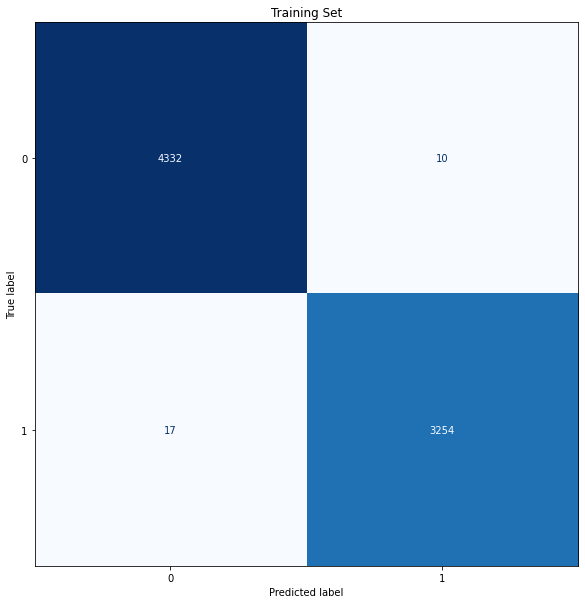

In [24]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_predicted))
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Training Set')
conf_mat_train.plot(cmap=plt.cm.Blues, colorbar=False, ax=ax);

In [25]:
X_test = testing_set["text"].apply(preprocessor)

In [26]:
y_test_predicted = grid.predict(X_test)

In [27]:
id = testing_set["id"].copy()
target = pd.DataFrame(y_test_predicted, columns=["target"])

In [28]:
submission = pd.merge(id, target, left_index=True, right_index=True)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [29]:
submission.to_csv("datasets/submission.csv", index=False)